In [2]:
from collections import defaultdict
from multiprocessing.pool import Pool
import json
import math
from typing import Callable, List, Union, Tuple, Dict, Any

from pathlib import Path
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import GridSearchCV, StratifiedKFold
import matplotlib as mpl
%matplotlib inline  
import seaborn as sns

# Models
from bella.models.tdparse import TDParseMinus, TDParse, TDParsePlus
from bella.models.base import SKLearnModel
# Word Vector methods
from bella.word_vectors import VoVectors, SSWE
from bella.helper import read_config
# Sentiment lexicons
from bella import lexicons
# Get the data
from bella.parsers import dong, election
# Tokenisers
from bella.tokenisers import ark_twokenize, stanford
# Dependency parsers
from bella import dependency_parsers

Using TensorFlow backend.


In [4]:
def all_words(tokeniser: Callable[[str], List[str]], 
              *datasets) -> List[str]:
    words = []
    for dataset in datasets:
        words.extend(dataset.word_list(tokeniser))
    return list(set(words))    

In [5]:
##
#  ADD YOUR CONFIG FILE PATH HERE 
##
CONFIG_FP = Path('..', 'config.yaml')

# Load the training data
dong_train = dong(read_config('dong_twit_train_data', CONFIG_FP))
dong_test = dong(read_config('dong_twit_test_data', CONFIG_FP))
X_dong_train, X_dong_test = dong_train.data(), dong_test.data()
y_dong_train, y_dong_test = dong_train.sentiment_data(),\
                            dong_test.sentiment_data()
election_train, election_test =\
election(read_config('election_folder_dir', CONFIG_FP))
X_elec_train, X_elec_test = election_train.data(), election_test.data()
y_elec_train, y_elec_test = election_train.sentiment_data(),\
                            election_test.sentiment_data()
# Get word vectors
# To reduce the number of vectors we load we only load
# the words that are within the train and test set
# which is still as fair in practice as loading the whole
# word vectors
dong_all_words = all_words(ark_twokenize, dong_train, dong_test)
elec_all_words = all_words(ark_twokenize, election_train, election_test)
dong_w2v = VoVectors(filter_words=dong_all_words)
dong_sswe = SSWE(filter_words=dong_all_words)
elec_w2v = VoVectors(filter_words=elec_all_words)
elec_sswe = SSWE(filter_words=elec_all_words)

# Getting the sentiment lexicons
hu_liu_fp = Path(read_config('hu_liu_lexicon', CONFIG_FP))
mpqa_fp = Path(read_config('mpqa_lexicon', CONFIG_FP))
nrc_fp = Path(read_config('nrc_emotion_lexicon', CONFIG_FP))

subset_cats = {'positive', 'negative'}
mpqa_low = lexicons.Mpqa(mpqa_fp, subset_cats=subset_cats, lower=True)
nrc_low = lexicons.NRC(nrc_fp, subset_cats=subset_cats, lower=True)
hu_liu_low = lexicons.HuLiu(hu_liu_fp, subset_cats=subset_cats, lower=True)
mpqa_huliu_low = lexicons.Lexicon.combine_lexicons(mpqa_low, hu_liu_low)
all_three_low = lexicons.Lexicon.combine_lexicons(mpqa_huliu_low, nrc_low)
###
#    Set here the number of cpus to use for all of the
#    grid searching
###

n_cpus = 7

results_folder = Path(read_config('results_folder', CONFIG_FP))
results_folder = results_folder.joinpath('TDParse')
results_folder.mkdir(parents=True, exist_ok=True)

# TDParse models
This notebook shows how to use the TDParse models and comparing the results of our implementation to the one in the original [paper](https://aclanthology.coli.uni-saarland.de/papers/E17-1046/e17-1046)

The paper had 4 different models however we have implemented 3 of them as the fourth **TDParse+ (m)** we have incorporated the same target multi appearence solution into all of the impleneted models therefore **TDParse+ (m)** is now redudant as it equals **TDParse+** in our models. The reason we did this was that we did not know which target appearence they used e.g. if there was three apearance of the same target did they use the first, second and last appearence? this is the reason why the authors created the multi appearence solution, however they did not describe how they implmented the models they did not use the multi appearence solution.

Models:
1. **TDParse-** -- This only used the syntactic connected words of the target word as context.
2. **TDParse** -- This used the syntactic connected words, left, right and target context.
3. **TDParse+** -- This used the same as **TDParse** but had two more contexts left and right sentiment contexts which filtered out words that are not in the sentiment lexicons.

The above models correspond to the following classes in our implementation:
1. [TDParseMinus](../tdparse/models/tdparse.py), 2. [TDParse](../tdparse/models/tdparse.py), 3. [TDParsePlus](../tdparse/models/tdparse.py)

The results reported are based on training and testing on the datasets of [Dong et al.](https://aclanthology.coli.uni-saarland.de/papers/P14-2009/p14-2009) and their own Election Twitter dataset which can be found [here](https://figshare.com/articles/EACL_2017_-_Multi-target_UK_election_Twitter_sentiment_corpus/4479563/1) as reported in the paper.

The notebook is going to show the results of the original paper using our implementation. We are then going to look at the affects of lower casing and scaling with respect to those results as these parts of the implementation were not mentioned in the original paper but we show the importance of these implementation details.

# Original Paper results
For each of the datasets we require to find the C-value for the Support Vector Machine (SVM) as this was not reported in the paper but is an important hyper-parameter to tune for. Therefore the start of each dataset we are going to find the Best C value for each of the models keeping everything else constant. The defualt tokeniser is the [Ark tokeniser](http://ttic.uchicago.edu/~kgimpel/papers/gimpel+etal.acl11.pdf) of which we use this python port of the [tokeniser](https://github.com/Sentimentron/ark-twokenize-py). Also we default to lower casing all tokens as well. For the sentiment lexicon method **TDParse+** we use the following lexicons:
1. [MPQA](http://mpqa.cs.pitt.edu/lexicons/subj_lexicon/), 2. [NRC](http://saifmohammad.com/WebPages/NRC-Emotion-Lexicon.htm), and 3. [Hu & Liu](https://www.cs.uic.edu/~liub/FBS/sentiment-analysis.html#lexicon)

**NOTE** In the original paper they adopted approaches from *Vo and Zhang 2015* and have used the same pre-trained embeddings, pooling functions and tunned the C value over the same set of parameter values. However they did not state if they were going to use the same tokeniser *Ark tokeniser* or the same set of lexicons. However they did release their code which can be found [here](https://github.com/bluemonk482/tdparse) which shows that they do use the *Ark tokeniser* and the lexicons stated above which were the full set of lexicons in *Vo and Zhang 2015*.

## Best C value Dong et al. Dataset

We store the results of the C values as finding C values can take a long time > 3 hours using 5 processors and ~8GB of RAM. This is due to the fact we have to dependency parse each time we train and test as we do not cache pre-processing data.

In [6]:
# Models
models = [TDParseMinus, TDParse, TDParsePlus]

In [8]:
# Getting the best C Value for the Dong Twitter dataset
c_values = [1] # include the default sklearn C Value
for c in range(-15, 3, 2):
    c_values.append(math.pow(2, c))
    
dong_best_c_fp = results_folder.joinpath('Dong Twitter Best C.json')
dong_best_c = None
# See if we have already got the result
if dong_best_c_fp.is_file():
    with dong_best_c_fp.open('r') as dong_best_c_file:
        dong_best_c = json.load(dong_best_c_file)
# If we have not we have to run each of the three models and then
# save the result
if dong_best_c is None:
    model_kwargs = []
    for model in models:
        kwargs = {'word_vectors': [[dong_w2v, dong_sswe]],
                  'parser': [dependency_parsers.tweebo]}
        if model == TDParsePlus:
            kwargs['senti_lexicon'] = [all_three_low]
        model_kwargs.append((model, kwargs))
    dong_best_c = SKLearnModel.models_best_parameter(model_kwargs,'C', c_values, 
                                                     X_dong_train, y_dong_train, 
                                                     n_cpus)
    dong_best_c = {model.name(): c for model, c in dong_best_c.items()}
    with dong_best_c_fp.open('w+') as dong_best_c_file:
        json.dump(dong_best_c, dong_best_c_file)
dong_best_c

{'TDParse Minus': '0.03125',
 'TDParse': '0.0078125',
 'TDParsePlus': '0.0078125'}

## Best C value Elections dataset

In [14]:
# Getting the best C Value for the Election Twitter dataset
c_values = [1] # include the default sklearn C Value
for c in range(-15, 3, 2):
    c_values.append(math.pow(2, c))
    
elec_best_c_fp = results_folder.joinpath('Election Twitter Best C.json')
elec_best_c = None
# See if we have already got the result
if elec_best_c_fp.is_file():
    with elec_best_c_fp.open('r') as elec_best_c_file:
        elec_best_c = json.load(elec_best_c_file)
# If we have not we have to run each of the three models and then
# save the result
if elec_best_c is None:
    model_kwargs = []
    for model in models:
        kwargs = {'word_vectors': [[elec_w2v, elec_sswe]],
                  'parser': [dependency_parsers.tweebo]}
        if model == TDParsePlus:
            kwargs['senti_lexicon'] = [all_three_low]
        model_kwargs.append((model, kwargs))
    elec_best_c = SKLearnModel.models_best_parameter(model_kwargs,'C', c_values, 
                                                     X_elec_train, y_elec_train, 
                                                     n_cpus)
    elec_best_c = {model.name(): c for model, c in elec_best_c.items()}
    with elec_best_c_fp.open('w+') as elec_best_c_file:
        json.dump(elec_best_c, elec_best_c_file)
elec_best_c

{'TDParse Minus': '0.0078125',
 'TDParse': '0.001953125',
 'TDParsePlus': '0.001953125'}

### Accuracy and Macro F1 scores on the Datasets

Below trains and tests on the two datasets and then displays the results comparing to the original results stated in the paper
**NOTE** Takes around 23 minutes to run on 3 processors and no more than 3-5 GB of RAM to reduce the amount of RAM use fewer processors in the Pool Instances.

In [28]:
def model_eval(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    acc = accuracy_score(y_test, predictions)
    f1 = f1_score(y_test, predictions, average='macro')
    return acc, f1


dataset_model_acc = defaultdict(lambda: dict())
dataset_model_f1 = defaultdict(lambda: dict())

dong_params = (dong_best_c, [dong_w2v, dong_sswe])
elec_params = (elec_best_c, [elec_w2v, elec_sswe])
dataset_data_params = {'Dong Twitter': ((dong_train, dong_test), dong_params),
                       'Election Twitter': ((election_train, election_test), elec_params)}
for dataset_name, data_params in dataset_data_params.items():
    data, params = data_params
    train, test = data
    X_train, y_train = train.data(), train.sentiment_data()
    X_test, y_test = test.data(), test.sentiment_data()
    
    c_values, dataset_word_embeddings = params
    model_instances_params = []
    for model in models:
        best_c = float(c_values[model.name()])
        if model == TDParsePlus:
            model_instance = model(dataset_word_embeddings,
                                   dependency_parsers.tweebo,
                                   C=best_c,
                                   senti_lexicon = all_three_low)
        else:
            model_instance = model(dataset_word_embeddings, 
                                   dependency_parsers.tweebo,
                                   C=best_c)
        func_params = (X_train, y_train, X_test, y_test) 
        model_instances_params.append((model_instance, *func_params))
    with Pool(3) as pool:
        model_acc_f1 = pool.starmap(model_eval, model_instances_params)
    for i, model in enumerate(models):
        acc, f1 = model_acc_f1[i]
        dataset_model_acc[dataset_name][model.name()] = acc
        dataset_model_f1[dataset_name][model.name()] = f1

TDParse Minus, ({'TDParse Minus': '0.03125', 'TDParse': '0.0078125', 'TDParsePlus': '0.0078125'}, [w2v, sswe])
0.03125
TDParse, ({'TDParse Minus': '0.03125', 'TDParse': '0.0078125', 'TDParsePlus': '0.0078125'}, [w2v, sswe])
0.0078125
TDParsePlus, ({'TDParse Minus': '0.03125', 'TDParse': '0.0078125', 'TDParsePlus': '0.0078125'}, [w2v, sswe])
0.0078125
defaultdict(<function <lambda> at 0x7f6f43e3e488>, {'Dong Twitter': {'TDParse Minus': 0.58795142054996008}})
defaultdict(<function <lambda> at 0x7f6f43e3e488>, {'Dong Twitter': {'TDParse Minus': 0.58795142054996008, 'TDParse': 0.66889543640346805}})
defaultdict(<function <lambda> at 0x7f6f43e3e488>, {'Dong Twitter': {'TDParse Minus': 0.58795142054996008, 'TDParse': 0.66889543640346805, 'TDParsePlus': 0.68103783201584822}})
TDParse Minus, ({'TDParse Minus': '0.0078125', 'TDParse': '0.001953125', 'TDParsePlus': '0.001953125'}, [w2v, sswe])
0.0078125
TDParse, ({'TDParse Minus': '0.0078125', 'TDParse': '0.001953125', 'TDParsePlus': '0.00195312

We are now going to add the scores from the paper.

In [41]:
paper_acc = {'Election Twitter (Paper)': {'TDParse Minus': 0.5253,
                                          'TDParse': 0.5645,
                                          'TDParsePlus': 0},
             'Dong Twitter (Paper)': {'TDParse Minus': 0.6170,
                                      'TDParse': 0.7100,
                                      'TDParsePlus': 0.7250}}
paper_f1 = {'Election Twitter (Paper)': {'TDParse Minus': 0.4271,
                                          'TDParse': 0.4609,
                                          'TDParsePlus': 0},
             'Dong Twitter (Paper)': {'TDParse Minus': 0.5700,
                                      'TDParse': 0.6840,
                                      'TDParsePlus': 0.7030}}

#### Macro F1

In [42]:
all_f1_scores = {**dataset_model_f1, **paper_f1}
all_f1_scores = (pd.DataFrame(all_f1_scores) * 100).round(2)
all_f1_scores

,Dong Twitter,Dong Twitter (Paper),Election Twitter,Election Twitter (Paper)
TDParse,66.89,68.4,39.27,46.09
TDParse Minus,58.80,57.0,37.27,42.71
TDParsePlus,68.10,70.3,41.70,0.00


#### Accuracy

In [43]:
all_acc_scores = {**dataset_model_acc, **paper_acc}
all_acc_scores = (pd.DataFrame(all_acc_scores) * 100).round(2)
all_acc_scores

,Dong Twitter,Dong Twitter (Paper),Election Twitter,Election Twitter (Paper)
TDParse,69.65,71.0,55.02,56.45
TDParse Minus,63.15,61.7,52.85,52.53
TDParsePlus,70.52,72.5,55.06,0.00


From what we can see above we are very close to the scores from the original paper and further more we have the same method ordering as in **TDParse+** > **TDParse** > **TDParse-**. Therefore we have successfully reproduced this paper.

The election dataset for the Macro F1 metric is by far the worse score differences. This could be due to the fact that we could not process the whole dataset and are therefore 688 examples/samples smaller than the dataset qouted in the original paper.

Finally you can see that **TDParse+** was not run on the Election dataset from the original paper but we can show here how it is still better than the non-sentiment version **TDParse** showing that using a range of sentiment lexicons is still effective in the Political domain as well as the more general domain of the Dong et al. dataset.

## The affect of scaling

Above we have shown how we have successfully reproduced the methods described in the paper. We are now going to show the one parameter we found that causes a large difference in the result, of which the parameter was not mentioned in the original paper.

We show below the affect of scaling the word vectors on the different methods. To scale we use [MinMax](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) scaling. They did use a different Support Vector Machine Library [LibLinear](https://www.csie.ntu.edu.tw/~cjlin/liblinear/) however we actually use the [Scikit-learn interface](http://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html) to this library. Even though in the [Practical guide to LibLinear](https://www.csie.ntu.edu.tw/~cjlin/papers/guide/guide.pdf) it states that you should scale and they also show this in their [README.md](https://github.com/bluemonk482/tdparse) of their code base but not in the paper. We show the importance of scaling.

In [46]:
def model_eval(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    acc = accuracy_score(y_test, predictions)
    f1 = f1_score(y_test, predictions, average='macro')
    return acc, f1


scale_dataset_model_acc = defaultdict(lambda: dict())
scale_dataset_model_f1 = defaultdict(lambda: dict())

dong_params = (dong_best_c, [dong_w2v, dong_sswe])
elec_params = (elec_best_c, [elec_w2v, elec_sswe])
dataset_data_params = {'Dong Twitter': ((dong_train, dong_test), dong_params),
                       'Election Twitter': ((election_train, election_test), elec_params)}
for dataset_name, data_params in dataset_data_params.items():
    data, params = data_params
    train, test = data
    X_train, y_train = train.data(), train.sentiment_data()
    X_test, y_test = test.data(), test.sentiment_data()
    
    c_values, dataset_word_embeddings = params
    model_instances_params = []
    for model in models:
        best_c = float(c_values[model.name()])
        # The main difference to the code from 4 cells 
        # back is the `scale` parameter in the model instances
        if model == TDParsePlus:
            model_instance = model(dataset_word_embeddings,
                                   dependency_parsers.tweebo,
                                   C=best_c, scale=None,
                                   senti_lexicon = all_three_low)
        else:
            model_instance = model(dataset_word_embeddings, 
                                   dependency_parsers.tweebo,
                                   C=best_c, scale=None)
        func_params = (X_train, y_train, X_test, y_test) 
        model_instances_params.append((model_instance, *func_params))
    with Pool(3) as pool:
        model_acc_f1 = pool.starmap(model_eval, model_instances_params)
    for i, model in enumerate(models):
        acc, f1 = model_acc_f1[i]
        scale_dataset_name = f'{dataset_name} (not scaled)'
        scale_dataset_model_acc[scale_dataset_name][model.name()] = acc
        scale_dataset_model_f1[scale_dataset_name][model.name()] = f1

#### Macro F1

In [56]:
all_scale_f1_scores = {**dataset_model_f1, **scale_dataset_model_f1, 
                       **paper_f1}
all_scale_f1_scores = (pd.DataFrame(all_scale_f1_scores) * 100).round(2)
all_scale_f1_scores

,Dong Twitter,Dong Twitter (Paper),Dong Twitter (not scaled),Election Twitter,Election Twitter (Paper),Election Twitter (not scaled)
TDParse,66.89,68.4,51.33,39.27,46.09,38.73
TDParse Minus,58.80,57.0,55.32,37.27,42.71,41.75
TDParsePlus,68.10,70.3,40.90,41.70,0.00,33.39


#### Accuracy

In [55]:
all_scale_acc_scores = {**dataset_model_acc, **scale_dataset_model_acc,
                        **paper_acc}
all_scale_acc_scores = (pd.DataFrame(all_scale_acc_scores) * 100).round(2)
all_scale_acc_scores

,Dong Twitter,Dong Twitter (Paper),Dong Twitter (not scaled),Election Twitter,Election Twitter (Paper),Election Twitter (not scaled)
TDParse,69.65,71.0,55.06,55.02,56.45,46.56
TDParse Minus,63.15,61.7,58.82,52.85,52.53,52.30
TDParsePlus,70.52,72.5,42.49,55.06,0.00,37.27


We are now going to plot the data as it is shown in the paper

In [67]:
def seaborn_data(dataset_model_metric, metric_name):
    seaborn_data = {'Model': [], 'Legend': [], f'{metric_name}': [],
                    'Dataset': []}
    for dataset_name, model_metric in dataset_model_metric.items():
        num_models = len(model_metric)
        if 'scaled' in dataset_name:
            seaborn_data['Legend'].extend(['Not Scaled'] * num_models)
        elif 'Paper' in dataset_name:
            seaborn_data['Legend'].extend(['Original'] * num_models)
        else:
            seaborn_data['Legend'].extend(['Reproduction'] * num_models)
        if 'Dong' in dataset_name:
            seaborn_data['Dataset'].extend(['Dong Twitter'] * num_models)
        else:
            seaborn_data['Dataset'].extend(['Election Twitter'] * num_models)
        for model, metric in model_metric.items():
            seaborn_data['Model'].append(model)
            seaborn_data[f'{metric_name}'].append(round(metric * 100, 2))
    return seaborn_data


# Need to transform the data into something that suits seaborn better
acc_data = {**dataset_model_acc, **scale_dataset_model_acc, **paper_acc}
acc_data = pd.DataFrame(seaborn_data(acc_data, 'Accuracy'))
f1_data = {**dataset_model_f1, **scale_dataset_model_f1, **paper_f1}
f1_data = pd.DataFrame(seaborn_data(f1_data, 'F1'))

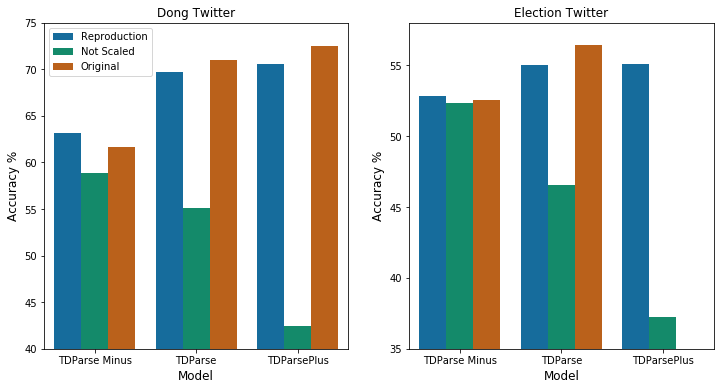

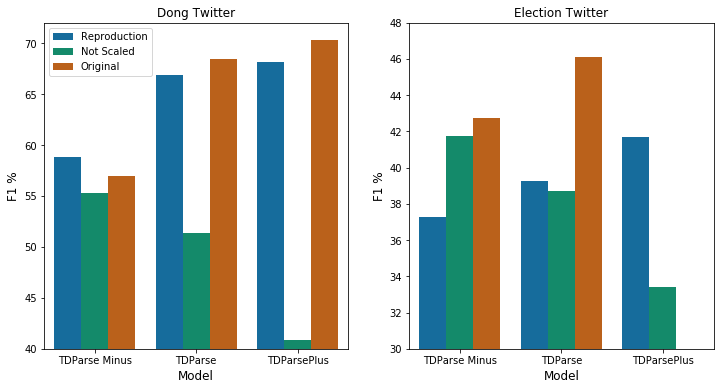

In [93]:
mpl.rcParams['axes.labelsize'] = 'large'

for metric_name, metric_data in [('Accuracy', acc_data), ('F1', f1_data)]:
    
    fig, axes = plt.subplots(1, 2, figsize=(12,6))
    for i, dataset_name in enumerate(['Dong Twitter', 'Election Twitter']):
        data = metric_data[acc_data['Dataset'] == dataset_name]
        ax = sns.barplot(x="Model", y=f'{metric_name}', hue="Legend", 
                         data=data, 
                         palette=sns.color_palette("colorblind"),
                         ax=axes[i])
        ax.set_title(f'{dataset_name}')
        leg = ax.legend()
        if dataset_name == 'Election Twitter':
            if metric_name == 'F1':
                ax.set(ylim=(30, 48))
            else:
                ax.set(ylim=(35, 58))
            leg.remove()
        else:
            if metric_name == 'F1':
                ax.set(ylim=(40, 72))
            else:
                ax.set(ylim=(40, 75))
        ax.set_ylabel(f'{metric_name} %')

As you can see not scaling the data (in this can we used [MinMax](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) scaling) affects the results quite a lot, more so for the models that contain more parameters e.g. TDParse+.

This scaling effect can also be seen in the Target Dependent models of which that notebook can be found [here](./target_model.ipynb)